Gradient Boosting Gridsearch 

In [60]:
%%time
# Data exploration
import matplotlib.pyplot as plt

# Data processing
import pickle
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.neural_network import MLPClassifier
#from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

# Experimental setup
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, GridSearchCV
#from imblearn.over_sampling import SMOTE, RandomOverSampler
#from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV, train_test_split

Wall time: 1 ms


### 2.6. Variable selection

<u>Reference:</u>  

- Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights into churn prediction in the telecommunication sector: A profit driven data mining approach. European Journal of Operational Research, 218(1), 211-229.

In [61]:
%%time
# Read back the processed data
train = pd.read_pickle("C:/Users/cgallet/OneDrive - IESEG/MBD/Statistical_ML for Marketing/Group Assignment/Processed Data/train_processed.pkl")
validation = pd.read_pickle("C:/Users/cgallet/OneDrive - IESEG/MBD/Statistical_ML for Marketing/Group Assignment/Processed Data/validation_processed.pkl")
test = pd.read_pickle("C:/Users/cgallet/OneDrive - IESEG/MBD/Statistical_ML for Marketing/Group Assignment/Processed Data/test_processed.pkl")

Wall time: 44.6 ms


In [62]:
%%time
# Create several lists to handle variables
id_var = ['client_id']
target_var = ['subscribe']
predictors = [v for v in train.columns if v not in id_var + target_var]

Wall time: 0 ns


####  (a) Variable selection: Fisher Score

In [63]:
%%time
def FisherScore(bt, target_var, predictors):
    """
    This function calculate the Fisher score of a variable.

    Ref:
    ---
    Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights
    into churn prediction in the telecommunication sector: A profit driven data mining
    approach. European Journal of Operational Research, 218(1), 211-229.
    """
    
    # Get the unique values of dependent variable
    target_var_val = bt[target_var].unique()
    # Calculate FisherScore for each predictor
    predictor_FisherScore = []
    for v in predictors:
        fs = np.abs(np.mean(bt.loc[bt[target_var]==target_var_val[0], v]) - np.mean(bt.loc[bt[target_var]==target_var_val[1], v])) / \
             np.sqrt(np.var(bt.loc[bt[target_var]==target_var_val[0], v]) + np.var(bt.loc[bt[target_var]==target_var_val[1], v]))
        predictor_FisherScore.append(fs)
    return predictor_FisherScore

Wall time: 0 ns


In [64]:
%%time
# Calculate Fisher Score for all variable
fs = FisherScore(train, target_var[0], predictors)
fs_df = pd.DataFrame({"predictor":predictors, "fisherscore":fs})
fs_df = fs_df.sort_values('fisherscore', ascending=False)
fs_df.head()

Wall time: 815 ms


,predictor,fisherscore
8,nr.employed,0.747921
7,euribor3m,0.706608
4,emp.var.rate,0.670617
2,pdays,0.468189
116,pdays_bin_4,0.467943


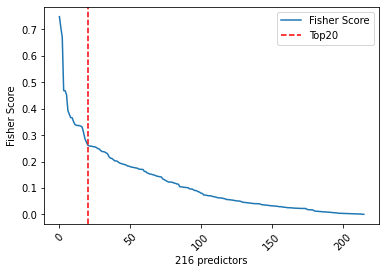

Wall time: 708 ms


In [65]:
%%time
# Visualize the Fisher Score
plt.plot(fs_df['fisherscore'].values.squeeze())
plt.axvline(x=20, linestyle='dashed', color='red')
plt.xticks(rotation=45)
plt.xlabel(str(fs_df.shape[0]) + ' predictors')
plt.ylabel('Fisher Score')
plt.legend(['Fisher Score', 'Top20'])
plt.show()

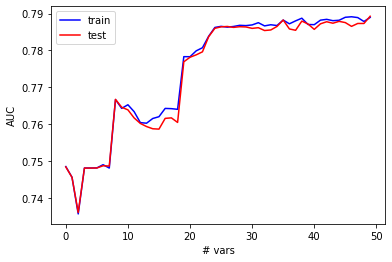

Wall time: 29.5 s


In [66]:
%%time
# Check how AUC change when add more variables: Top n vars
fs_scores = []
top_n_vars = 50
for i in range(1, top_n_vars+1):
    if i % 100 == 0: print('Added # top vars :', i)
    top_n_predictors = fs_df['predictor'][:i]
    clf = LogisticRegression()
    fs_scores.append(cross_validate(clf, train[top_n_predictors], train[target_var].values.squeeze(),
                                    scoring='roc_auc', cv=5, verbose=0, n_jobs=-1, return_train_score=True))

# How the AUC curve looks like when adding top vars
plt.plot([s['train_score'].mean() for s in fs_scores], color='blue')
plt.plot([s['test_score'].mean() for s in fs_scores], color='red')
plt.xlabel('# vars')
plt.ylabel('AUC')
plt.legend(['train', 'test'])
plt.show()

In [67]:
%%time
# Select the top variables based on Fisher Score
n_top_fs_vars = 50  # Top FS vars
top_fs_vars = fs_df['predictor'].values[:n_top_fs_vars]
print("Selected # vars :", len(top_fs_vars))
top_fs_vars

Selected # vars : 50
Wall time: 0 ns


array(['nr.employed', 'euribor3m', 'emp.var.rate', 'pdays', 'pdays_bin_4',
       'poutcome_3.0', 'previous', 'poutcome_2.0', 'emp.var.rate_bin_14',
       'nr.employed_bin_16', 'pdays_bin_3', 'cons.price.idx_bin_21',
       'contact_2.0', 'nr.employed_bin_13', 'emp.var.rate_bin_13',
       'cons.conf.idx_bin_20', 'contact_1.0', 'previous_bin_6',
       'nr.employed_bin_8', 'cons.price.idx', 'cons.conf.idx_bin_23',
       'nr.employed_bin_9', 'emp.var.rate_bin_5', 'month_7.0',
       'default_remap_4', 'default_2.0', 'emp.var.rate_bin_8',
       'nr.employed_bin_6', 'nr.employed_bin_7', 'cons.price.idx_bin_25',
       'cons.conf.idx_bin_18', 'cons.price.idx_bin_5', 'default_1.0',
       'cons.conf.idx_bin_17', 'emp.var.rate_bin_9', 'previous_bin_5',
       'month_9.0', 'cons.price.idx_bin_4', 'euribor3m_bin_60',
       'cons.conf.idx_bin_27', 'month_10.0', 'month_6.0',
       'euribor3m_bin_7', 'cons.price.idx_bin_17', 'age_bin_76',
       'euribor3m_bin_4', 'cons.conf.idx_bin_21', 'eu

In [68]:
print(train.shape)
print(validation.shape)
print(test.shape)

(16000, 218)
(4000, 218)
(10000, 217)


## 3. Modeling

In [69]:
%%time

#Subset the train, validation, and test sets to keep only the features selected through the fisher score

X_train = train[top_fs_vars]
X_validation = validation[top_fs_vars]
X_test = test[top_fs_vars]

test_id = test[id_var]


y_train = train[target_var]
y_validation = validation[target_var]


Wall time: 14.3 ms


### 3.1. Modeling

In [70]:
# Instanciate the models

tree         = DecisionTreeClassifier()
logistic     = LogisticRegression(solver = "lbfgs", max_iter = 500)
randomForest = RandomForestClassifier(n_estimators = 100)
boostedTree  = GradientBoostingClassifier()
svm          = SVC(gamma = "scale", probability = True)
neuralNet    = MLPClassifier()
neighbors    = KNeighborsClassifier()

In [71]:
models = {"Decision Tree"         :tree,
          "Logistic Regression"     :logistic,
          "Random Forest" :randomForest,
          "Boosted Tree"  :boostedTree,
          "SVM"          :svm,
          "NeuralNet"    :neuralNet,
          "KNN"    :neighbors
         }

In [17]:
#Train the models on the train set

for model in models:
    models[model].fit(X_train, y_train)
    


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-17-f2401b60a26d>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  models[model].fit(X_train, y_train)
C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = co

In [18]:
#Predict on the train and validation to evaluate and compare

performances = {}

for model in models:
    train_pred          = models[model].predict(X_train)
    validation_pred     = models[model].predict(X_validation)
    train_prob          = pd.DataFrame(models[model].predict_proba(X_train))[1]
    validation_prob     = pd.DataFrame(models[model].predict_proba(X_validation))[1]
    train_accuracy      = accuracy_score(y_train, train_pred)
    validation_accuracy = accuracy_score(y_validation, validation_pred)
    train_auc           = roc_auc_score(np.array(y_train),np.array(train_prob))
    validation_auc      = roc_auc_score(np.array(y_validation),np.array(validation_prob))
    train_f1            = f1_score(y_train, train_pred)
    validation_f1       = f1_score(y_validation, validation_pred)
    
    performances[model] = {"Validation Accuracy": validation_accuracy, "Train Accuracy": train_accuracy, "Validation AUC": validation_auc, "Train AUC": train_auc, "Validation F1": validation_f1, "Train F1": train_f1}

In [19]:
pd.DataFrame(performances).T

,Validation Accuracy,Train Accuracy,Validation AUC,Train AUC,Validation F1,Train F1
Decision Tree,0.89125,0.929312,0.691243,0.887035,0.345865,0.565501
Logistic Regression,0.89625,0.901687,0.788269,0.789066,0.323002,0.353473
Random Forest,0.88900,0.929312,0.768986,0.875958,0.358382,0.582194
Boosted Tree,0.89525,0.905563,0.795659,0.806551,0.325282,0.394389
SVM,0.89600,0.897938,0.721191,0.721484,0.315789,0.323249
NeuralNet,0.89400,0.896000,0.788853,0.789762,0.178295,0.204589
KNN,0.89275,0.910250,0.728337,0.791452,0.384505,0.473993


####  (a) Hyper-parameter tuning: Gridsearch over highest performaning models 

In [20]:
%%time
#Grid search over Boosted Tree with 5 CV folds
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = GradientBoostingClassifier()
parameters = {'min_samples_leaf':(X_train.shape[0]*np.array([0.01, 0.05, 0.1, 0.25, 0.5])).astype(int), 'min_samples_split':[400,500,600,750], 'max_depth':[4,5,6,7,8], 'learning_rate':[0.1,0.5,1]}
gs_gbc = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-2, cv=cv, verbose=3)
gs_gbc.fit(X_train, y_train)

print(gs_gbc.best_estimator_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(learning_rate=0.5, max_depth=4, min_samples_leaf=160,
                           min_samples_split=600)
Wall time: 11min 29s


In [22]:
boosting = GradientBoostingClassifier(learning_rate=0.5, max_depth=4, min_samples_leaf=160, min_samples_split=600)

models = {"GradientBoosting" :boosting
         }

for model in models:
    models[model].fit(X_train, y_train)

performances = {}

for model in models:
    train_pred          = models[model].predict(X_train)
    validation_pred     = models[model].predict(X_validation)
    train_prob          = pd.DataFrame(models[model].predict_proba(X_train))[1]
    validation_prob     = pd.DataFrame(models[model].predict_proba(X_validation))[1]
    train_accuracy      = accuracy_score(y_train, train_pred)
    validation_accuracy = accuracy_score(y_validation, validation_pred)
    train_auc           = roc_auc_score(np.array(y_train),np.array(train_prob))
    validation_auc      = roc_auc_score(np.array(y_validation),np.array(validation_prob))
    train_f1            = f1_score(y_train, train_pred)
    validation_f1       = f1_score(y_validation, validation_pred)
    
    performances[model] = {"Validation Accuracy": validation_accuracy, "Train Accuracy": train_accuracy, "Validation AUC": validation_auc, "Train AUC": train_auc, "Validation F1": validation_f1, "Train F1": train_f1}
    
pd.DataFrame(performances).T

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Train AUC,Train Accuracy,Train F1,Validation AUC,Validation Accuracy,Validation F1
GradientBoosting,0.817714,0.906563,0.406511,0.793244,0.8985,0.353503


In [23]:
%%time
#Grid search over Boosted Tree with 10 CV folds
cv = KFold(n_splits=10, random_state=1, shuffle=True)
model = GradientBoostingClassifier()
parameters = {'min_samples_leaf':(X_train.shape[0]*np.array([0.01, 0.05, 0.1, 0.25, 0.5])).astype(int), 'min_samples_split':[400,500,600,750], 'max_depth':[5,6,7,8], 'learning_rate':[0.1,0.5,1]}
gs_gbc = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-2, cv=cv, verbose=3)
gs_gbc.fit(X_train, y_train)

print(gs_gbc.best_estimator_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(learning_rate=0.5, max_depth=5, min_samples_leaf=160,
                           min_samples_split=600)
Wall time: 31min 54s


In [24]:
boosting = GradientBoostingClassifier(learning_rate=0.5, max_depth=5, min_samples_leaf=160, min_samples_split=600)

models = {"GradientBoosting" :boosting
         }

for model in models:
    models[model].fit(X_train, y_train)

performances = {}

for model in models:
    train_pred          = models[model].predict(X_train)
    validation_pred     = models[model].predict(X_validation)
    train_prob          = pd.DataFrame(models[model].predict_proba(X_train))[1]
    validation_prob     = pd.DataFrame(models[model].predict_proba(X_validation))[1]
    train_accuracy      = accuracy_score(y_train, train_pred)
    validation_accuracy = accuracy_score(y_validation, validation_pred)
    train_auc           = roc_auc_score(np.array(y_train),np.array(train_prob))
    validation_auc      = roc_auc_score(np.array(y_validation),np.array(validation_prob))
    train_f1            = f1_score(y_train, train_pred)
    validation_f1       = f1_score(y_validation, validation_pred)
    
    performances[model] = {"Validation Accuracy": validation_accuracy, "Train Accuracy": train_accuracy, "Validation AUC": validation_auc, "Train AUC": train_auc, "Validation F1": validation_f1, "Train F1": train_f1}
    
pd.DataFrame(performances).T

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Train AUC,Train Accuracy,Train F1,Validation AUC,Validation Accuracy,Validation F1
GradientBoosting,0.820122,0.907312,0.417289,0.790054,0.898,0.364486


In [25]:
%%time
#Grid search over Boosted Tree with 10 CV folds
cv = KFold(n_splits=10, random_state=1, shuffle=True)
model = GradientBoostingClassifier()
parameters = {'min_samples_leaf':(X_train.shape[0]*np.array([0.01, 0.05, 0.1, 0.25, 0.5])).astype(int), 'min_samples_split':[500,550,600,650,750], 'max_depth':[4,5,6,7,8], 'learning_rate':[0.1,0.5,1], 'n_estimators':[10, 50, 100, 250, 500, 1000]}
gs_gbc = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-2, cv=cv, verbose=3)
gs_gbc.fit(X_train, y_train)

print(gs_gbc.best_estimator_)

Fitting 10 folds for each of 2250 candidates, totalling 22500 fits


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(learning_rate=0.5, max_depth=5, min_samples_leaf=160,
                           min_samples_split=600)
Wall time: 10h 29min 48s


In [26]:
boosting = GradientBoostingClassifier(learning_rate=0.5, max_depth=5, min_samples_leaf=160, min_samples_split=600)

models = {"GradientBoosting" :boosting
         }

for model in models:
    models[model].fit(X_train, y_train)

performances = {}

for model in models:
    train_pred          = models[model].predict(X_train)
    validation_pred     = models[model].predict(X_validation)
    train_prob          = pd.DataFrame(models[model].predict_proba(X_train))[1]
    validation_prob     = pd.DataFrame(models[model].predict_proba(X_validation))[1]
    train_accuracy      = accuracy_score(y_train, train_pred)
    validation_accuracy = accuracy_score(y_validation, validation_pred)
    train_auc           = roc_auc_score(np.array(y_train),np.array(train_prob))
    validation_auc      = roc_auc_score(np.array(y_validation),np.array(validation_prob))
    train_f1            = f1_score(y_train, train_pred)
    validation_f1       = f1_score(y_validation, validation_pred)
    
    performances[model] = {"Validation Accuracy": validation_accuracy, "Train Accuracy": train_accuracy, "Validation AUC": validation_auc, "Train AUC": train_auc, "Validation F1": validation_f1, "Train F1": train_f1}
    
pd.DataFrame(performances).T

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Train AUC,Train Accuracy,Train F1,Validation AUC,Validation Accuracy,Validation F1
GradientBoosting,0.820122,0.907312,0.417289,0.790054,0.898,0.364486


In [32]:
%%time
#Grid search over Boosted Tree with 10 CV folds
cv = KFold(n_splits=10, random_state=1, shuffle=True)
model = GradientBoostingClassifier()
parameters = {'min_samples_leaf':(X_train.shape[0]*np.array([0.01, 0.05, 0.1, 0.25, 0.5])).astype(int), 'min_samples_split':[550,575,600,625], 'max_depth':[5,6,7], 'learning_rate':[0.001,0.01,0.1,0.5,1], 'n_estimators':[500]}
gs_gbc = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-2, cv=cv, verbose=3)
gs_gbc.fit(X_train, y_train)

print(gs_gbc.best_estimator_)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(max_depth=5, min_samples_leaf=160,
                           min_samples_split=550, n_estimators=500)
Wall time: 2h 17min 53s


In [34]:
boosting = GradientBoostingClassifier(max_depth=5,min_samples_leaf=160,min_samples_split=550, n_estimators=500)

models = {"GradientBoosting" :boosting
         }

for model in models:
    models[model].fit(X_train, y_train)

performances = {}

for model in models:
    train_pred          = models[model].predict(X_train)
    validation_pred     = models[model].predict(X_validation)
    train_prob          = pd.DataFrame(models[model].predict_proba(X_train))[1]
    validation_prob     = pd.DataFrame(models[model].predict_proba(X_validation))[1]
    train_accuracy      = accuracy_score(y_train, train_pred)
    validation_accuracy = accuracy_score(y_validation, validation_pred)
    train_auc           = roc_auc_score(np.array(y_train),np.array(train_prob))
    validation_auc      = roc_auc_score(np.array(y_validation),np.array(validation_prob))
    train_f1            = f1_score(y_train, train_pred)
    validation_f1       = f1_score(y_validation, validation_pred)
    
    performances[model] = {"Validation Accuracy": validation_accuracy, "Train Accuracy": train_accuracy, "Validation AUC": validation_auc, "Train AUC": train_auc, "Validation F1": validation_f1, "Train F1": train_f1}
    
pd.DataFrame(performances).T

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Train AUC,Train Accuracy,Train F1,Validation AUC,Validation Accuracy,Validation F1
GradientBoosting,0.819986,0.907,0.41046,0.792701,0.899,0.362776


In [47]:
%%time
#Grid search over Boosted Tree with 10 CV folds
cv = KFold(n_splits=10, random_state=1, shuffle=True)
model = GradientBoostingClassifier()
parameters = {'min_samples_leaf':[150,160,170], 'loss':['deviance', 'exponential'], 'min_samples_split':[550,560,580,600], 'max_depth':[5,6,7], 'learning_rate':[0.25,0.5,0.75], 'n_estimators':[10, 50, 100]}
gs_gbc = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-2, cv=cv, verbose=3)
gs_gbc.fit(X_train, y_train)

print(gs_gbc.best_params_)

Fitting 10 folds for each of 648 candidates, totalling 6480 fits


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'learning_rate': 0.5, 'loss': 'deviance', 'max_depth': 5, 'min_samples_leaf': 160, 'min_samples_split': 580, 'n_estimators': 100}
Wall time: 53min 36s


In [48]:
    boosting = GradientBoostingClassifier(learning_rate=0.5, loss='deviance',max_depth=5,min_samples_leaf=160,min_samples_split=580, n_estimators=100)

models = {"GradientBoosting" :boosting
         }

for model in models:
    models[model].fit(X_train, y_train)

performances = {}

for model in models:
    train_pred          = models[model].predict(X_train)
    validation_pred     = models[model].predict(X_validation)
    train_prob          = pd.DataFrame(models[model].predict_proba(X_train))[1]
    validation_prob     = pd.DataFrame(models[model].predict_proba(X_validation))[1]
    train_accuracy      = accuracy_score(y_train, train_pred)
    validation_accuracy = accuracy_score(y_validation, validation_pred)
    train_auc           = roc_auc_score(np.array(y_train),np.array(train_prob))
    validation_auc      = roc_auc_score(np.array(y_validation),np.array(validation_prob))
    train_f1            = f1_score(y_train, train_pred)
    validation_f1       = f1_score(y_validation, validation_pred)
    
    performances[model] = {"Validation Accuracy": validation_accuracy, "Train Accuracy": train_accuracy, "Validation AUC": validation_auc, "Train AUC": train_auc, "Validation F1": validation_f1, "Train F1": train_f1}
    
pd.DataFrame(performances).T

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Train AUC,Train Accuracy,Train F1,Validation AUC,Validation Accuracy,Validation F1
GradientBoosting,0.822882,0.907438,0.42171,0.789943,0.8975,0.359375


In [49]:
%%time
#Grid search over Boosted Tree with 10 CV folds
cv = KFold(n_splits=10, random_state=1, shuffle=True)
model = GradientBoostingClassifier()
parameters = {'min_samples_leaf':[155,160,165], 'loss':['deviance', 'exponential'], 'min_samples_split':[500,600,700], 'max_depth':[6,7,8], 'learning_rate':[0.25,0.5,1], 'n_estimators':[150,200,250]}
gs_gbc = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=3)
gs_gbc.fit(X_train, y_train)

print(gs_gbc.best_params_)

Fitting 10 folds for each of 486 candidates, totalling 4860 fits


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'learning_rate': 0.25, 'loss': 'deviance', 'max_depth': 6, 'min_samples_leaf': 165, 'min_samples_split': 700, 'n_estimators': 150}
Wall time: 3h 1min 38s


In [50]:
boosting = GradientBoostingClassifier(learning_rate=0.25, loss='deviance',max_depth=6,min_samples_leaf=165,min_samples_split=700, n_estimators=150)

models = {"GradientBoosting" :boosting
         }

for model in models:
    models[model].fit(X_train, y_train)

performances = {}

for model in models:
    train_pred          = models[model].predict(X_train)
    validation_pred     = models[model].predict(X_validation)
    train_prob          = pd.DataFrame(models[model].predict_proba(X_train))[1]
    validation_prob     = pd.DataFrame(models[model].predict_proba(X_validation))[1]
    train_accuracy      = accuracy_score(y_train, train_pred)
    validation_accuracy = accuracy_score(y_validation, validation_pred)
    train_auc           = roc_auc_score(np.array(y_train),np.array(train_prob))
    validation_auc      = roc_auc_score(np.array(y_validation),np.array(validation_prob))
    train_f1            = f1_score(y_train, train_pred)
    validation_f1       = f1_score(y_validation, validation_pred)
    
    performances[model] = {"Validation Accuracy": validation_accuracy, "Train Accuracy": train_accuracy, "Validation AUC": validation_auc, "Train AUC": train_auc, "Validation F1": validation_f1, "Train F1": train_f1}
    
pd.DataFrame(performances).T

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Train AUC,Train Accuracy,Train F1,Validation AUC,Validation Accuracy,Validation F1
GradientBoosting,0.820829,0.907062,0.414336,0.792592,0.89875,0.364207


## 4. Make prediction

Use the best model to make prediction on test set. Submit the result to Kaggle.

In [51]:
test_prob = pd.DataFrame(boosting.predict_proba(X_test))

In [52]:
test_prob['client_id'] = test_id
test_prob.rename(columns = {1:'subscribe'}, inplace = True)

In [53]:
kaggle_submission = test_prob[['client_id', 'subscribe']]

In [54]:
kaggle_submission

,client_id,subscribe
0,2986,0.065005
1,29710,0.048007
2,38938,0.340640
3,31313,0.064330
4,24173,0.090250
...,...,...
9995,880,0.329882
9996,28072,0.163030
9997,40491,0.044052
9998,5310,0.058849


In [55]:
kaggle_submission.to_csv("C:/Users/cgallet/OneDrive - IESEG/MBD/Statistical_ML for Marketing/Group Assignment/Submissions/submission.csv", index = False)